In [1]:
!pip install -q openai moviepy networkx torch torchvision torchaudio
!pip install -q transformers accelerate pillow nano-vectordb
!pip install -q open_clip_torch timm scikit-learn
!pip install -q bitsandbytes  # For 4-bit quantization

print("✅ All dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 32.8 MB/s eta 0:00:00:00:0100:01
✅ All dependencies installed


In [2]:
!pip install -q sentence-transformers 

In [3]:
import os
import json
import uuid
import warnings
import torch
import networkx as nx
import open_clip
from PIL import Image
from moviepy.video.io.VideoFileClip import VideoFileClip
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from openai import OpenAI
from nano_vectordb import NanoVectorDB
from IPython.display import display, Markdown, HTML

warnings.filterwarnings('ignore')
print("✅ Libraries imported successfully")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Libraries imported successfully


In [ ]:
class Config:
    """Global configuration for VideoRAG system"""
    # Directories
    UPLOAD_FOLDER = '/kaggle/working/data/videos'
    STORAGE_FOLDER = '/kaggle/working/data/storage'
    
    # ⚠️ REPLACE WITH YOUR OPENAI API KEY
    OPENAI_API_KEY = ""  # CHANGE THIS!
    
    # ⚠️ REPLACE WITH YOUR HUGGING FACE TOKEN (for MiniCPM-V access)
    # Get your token from: https://huggingface.co/settings/tokens
    HUGGINGFACE_TOKEN = ""  # CHANGE THIS!
    
    # Model configurations
    EMBEDDING_MODEL = "sentence-transformers/all-mpnet-base-v2"
    EMBEDDING_DIM = 768  # Dimension for all-mpnet-base-v2
    USE_LOCAL_EMBEDDINGS = True  # Using local embeddings instead of OpenAI
    
    LLM_MODEL = "gpt-4o-mini"
    
    # Create directories
    os.makedirs(UPLOAD_FOLDER, exist_ok=True)
    os.makedirs(STORAGE_FOLDER, exist_ok=True)

print("✅ Configuration loaded")
print(f"📁 Videos folder: {Config.UPLOAD_FOLDER}")
print(f"📁 Storage folder: {Config.STORAGE_FOLDER}")
print(f"🔤 Text Embeddings: {Config.EMBEDDING_MODEL} ({Config.EMBEDDING_DIM} dims)")

# Initialize OpenAI Client
client = OpenAI(api_key=Config.OPENAI_API_KEY)

✅ Configuration loaded
📁 Videos folder: /kaggle/working/data/videos
📁 Storage folder: /kaggle/working/data/storage
🔤 Text Embeddings: sentence-transformers/all-mpnet-base-v2 (768 dims)


In [5]:
class AIEngine:
    """
    Handles all AI model operations:
    - OpenCLIP for visual embeddings (GPU 0)
    - MiniCPM-V for vision-language understanding (GPU 1, 4-bit quantized)
    - Sentence-Transformers for text embeddings (GPU 0)
    - OpenAI API for transcription and LLM
    """
    def __init__(self):
        # GPU Strategy: Split models across 2 T4 GPUs
        self.device_main = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.device_vlm = "cuda:1" if torch.cuda.device_count() > 1 else "cuda:0"
        
        print(f"⚡ AI Engine Strategy:")
        print(f"   - CLIP/Text Embeddings: {self.device_main}")
        print(f"   - MiniCPM-V (VLM): {self.device_vlm}")
        print(f"   - Available GPUs: {torch.cuda.device_count()}")

        # 1. VISUAL EMBEDDING MODEL (OpenCLIP) -> GPU 0
        print("\n📦 Loading Visual Encoder (OpenCLIP)...")
        try:
            self.clip_model, _, self.clip_preprocess = open_clip.create_model_and_transforms(
                'ViT-B-32', 
                pretrained='laion2b_s34b_b79k'
            )
            self.clip_model.to(self.device_main)
            self.clip_model.eval()
            self.clip_tokenizer = open_clip.get_tokenizer('ViT-B-32')
            print(f"   ✅ OpenCLIP loaded on {self.device_main}")
        except Exception as e:
            print(f"   ❌ OpenCLIP failed: {e}")
            raise

        # 2. TEXT EMBEDDING MODEL (Sentence-Transformers) -> GPU 0
        print(f"\n📦 Loading Text Embeddings ({Config.EMBEDDING_MODEL})...")
        try:
            from sentence_transformers import SentenceTransformer
            self.text_model = SentenceTransformer(Config.EMBEDDING_MODEL)
            self.text_model.to(self.device_main)
            print(f"   ✅ Sentence-Transformers loaded on {self.device_main}")
            print(f"   ✅ Embedding dimension: {Config.EMBEDDING_DIM}")
        except Exception as e:
            print(f"   ❌ Text embeddings failed: {e}")
            raise

        # 3. VISION-LANGUAGE MODEL (MiniCPM-V) -> GPU 1 (4-bit Quantized)
        self.vlm_model = None
        self.vlm_tokenizer = None
        
        print("\n📦 Loading VLM (MiniCPM-V-2_6) with 4-bit quantization...")
        
        # Check if HuggingFace token is set
        if Config.HUGGINGFACE_TOKEN == "hf_your_token_here":
            print("   ⚠️ HuggingFace token not configured!")
            print("   ⚠️ Please set Config.HUGGINGFACE_TOKEN in Cell 3")
            print("   ⚠️ Get your token from: https://huggingface.co/settings/tokens")
            print("   ⚠️ VLM will NOT be loaded - system will run with limited visual captions")
        else:
            try:
                # Login to HuggingFace with the provided token
                from huggingface_hub import login
                login(token=Config.HUGGINGFACE_TOKEN)
                print("   ✅ HuggingFace authentication successful")
                
                # 4-bit quantization to fit in T4 memory
                bnb_config = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_compute_dtype=torch.float16,
                    bnb_4bit_quant_type="nf4"
                )

                self.vlm_model = AutoModel.from_pretrained(
                    "openbmb/MiniCPM-V-2_6", 
                    trust_remote_code=True, 
                    quantization_config=bnb_config,
                    device_map=self.device_vlm,
                    low_cpu_mem_usage=True,
                    token=Config.HUGGINGFACE_TOKEN
                )
                
                self.vlm_tokenizer = AutoTokenizer.from_pretrained(
                    "openbmb/MiniCPM-V-2_6", 
                    trust_remote_code=True,
                    token=Config.HUGGINGFACE_TOKEN
                )
                self.vlm_model.eval()
                print(f"   ✅ MiniCPM-V loaded (4-bit) on {self.device_vlm}")
            except Exception as e:
                print(f"   ⚠️ VLM load failed: {e}")
                print("   ⚠️ Common issues:")
                print("      - Invalid or expired HuggingFace token")
                print("      - No access to gated model (request access at model page)")
                print("      - Insufficient GPU memory")
                print("   System will run without detailed visual captions")

    def get_visual_embedding(self, image_path):
        """Generate dense vector for video frame using CLIP"""
        image = self.clip_preprocess(Image.open(image_path)).unsqueeze(0).to(self.device_main)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
        # Return as numpy array - nano-vectordb handles the conversion
        return image_features.cpu().numpy()[0].astype('float32')

    def get_text_embedding_clip(self, text):
        """Generate vector for text query in visual space"""
        text_tokens = self.clip_tokenizer([text]).to(self.device_main)
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text_tokens)
        # Return as numpy array - nano-vectordb handles the conversion
        return text_features.cpu().numpy()[0].astype('float32')

    def get_text_embedding_openai(self, text):
        """Generate text embedding using Sentence-Transformers (local model)"""
        import numpy as np
        embedding = self.text_model.encode(text, convert_to_numpy=True)
        return embedding.astype('float32')

    def generate_detailed_caption(self, image_path):
        """Generate detailed scene description using VLM"""
        if not self.vlm_model:
            return "Visual description unavailable (VLM not loaded)."
        
        try:
            image = Image.open(image_path).convert('RGB')
            msgs = [{'role': 'user', 'content': 'Describe this video scene in detail.'}]
            res = self.vlm_model.chat(
                image=image, 
                msgs=msgs, 
                tokenizer=self.vlm_tokenizer
            )
            return res
        except Exception as e:
            print(f"   ⚠️ Caption generation error: {e}")
            return "Error analyzing frame."

    def transcribe_audio(self, audio_path):
        """Transcribe audio using OpenAI Whisper API"""
        try:
            with open(audio_path, "rb") as audio_file:
                transcription = client.audio.transcriptions.create(
                    model="whisper-1", 
                    file=audio_file
                )
            return transcription.text
        except Exception as e:
            print(f"   ⚠️ Transcription error: {e}")
            return "[No Audio]"

    def extract_graph_entities(self, text):
        """Extract entities and relations for knowledge graph"""
        prompt = f"""
        Extract Entities and Relations from: "{text}"
        Output strictly valid JSON:
        {{ "entities": [ {{"name": "X", "type": "Y"}} ], "relations": [ {{"source": "X", "target": "Y", "relation": "Z"}} ] }}
        """
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                response_format={"type": "json_object"}
            )
            return json.loads(response.choices[0].message.content)
        except Exception as e:
            print(f"   ⚠️ Graph extraction error: {e}")
            return {"entities": [], "relations": []}

    def decompose_query(self, user_query):
        """Decompose user query into visual, textual, and graph components"""
        prompt = f"""
        Decompose query: "{user_query}"
        Output JSON: {{ "visual_query": "...", "keyword_query": "...", "entities": ["..."] }}
        """
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                response_format={"type": "json_object"}
            )
            return json.loads(response.choices[0].message.content)
        except Exception as e:
            print(f"   ⚠️ Query decomposition error: {e}")
            return {
                "visual_query": user_query, 
                "keyword_query": user_query, 
                "entities": []
            }

print("✅ AIEngine class defined")

✅ AIEngine class defined


In [6]:
class GraphEngine:
    """
    Manages knowledge graph construction and retrieval
    - Nodes: Entities extracted from video
    - Edges: Relationships between entities
    - Metadata: Links back to video chunks
    """
    def __init__(self):
        self.graph_path = os.path.join(Config.STORAGE_FOLDER, "knowledge_graph.json")
        self.G = nx.Graph()
        self.load()

    def add_knowledge(self, entities, relations, source_chunk_id):
        """Add entities and relations to the knowledge graph"""
        for ent in entities:
            name = ent['name'].lower()
            if not self.G.has_node(name):
                self.G.add_node(name, type=ent['type'], chunks=[])
            
            # Link entity to video chunk
            if source_chunk_id not in self.G.nodes[name]['chunks']:
                self.G.nodes[name]['chunks'].append(source_chunk_id)

        for rel in relations:
            src = rel['source'].lower()
            tgt = rel['target'].lower()
            if self.G.has_node(src) and self.G.has_node(tgt):
                self.G.add_edge(src, tgt, relation=rel['relation'])

    def retrieve_context(self, entities, hops=1):
        """Traverse graph to find related video chunks"""
        relevant_chunks = set()
        for entity in entities:
            entity = entity.lower()
            if self.G.has_node(entity):
                # 0-hop: The entity itself
                relevant_chunks.update(self.G.nodes[entity]['chunks'])
                
                # 1-hop: Neighbors
                if hops > 0:
                    for neighbor in self.G.neighbors(entity):
                        relevant_chunks.update(self.G.nodes[neighbor]['chunks'])
        
        return list(relevant_chunks)

    def save(self):
        """Save graph to disk"""
        data = nx.node_link_data(self.G)
        with open(self.graph_path, 'w') as f:
            json.dump(data, f)

    def load(self):
        """Load graph from disk"""
        if os.path.exists(self.graph_path):
            try:
                with open(self.graph_path, 'r') as f:
                    data = json.load(f)
                self.G = nx.node_link_graph(data)
                print(f"   📊 Loaded graph with {self.G.number_of_nodes()} nodes")
            except Exception as e:
                print(f"   ⚠️ Could not load graph: {e}")

print("✅ GraphEngine class defined")

✅ GraphEngine class defined


In [7]:
class VectorEngine:
    """
    Manages vector databases for similarity search
    - Text DB: Stores text embeddings (768 dims for all-mpnet-base-v2)
    - Visual DB: Stores visual embeddings (512 dims for CLIP)
    """
    def __init__(self):
        self.text_db_path = os.path.join(Config.STORAGE_FOLDER, "text_index.json")
        self.visual_db_path = os.path.join(Config.STORAGE_FOLDER, "visual_index.json")
        
        # 768 for Sentence-Transformers all-mpnet-base-v2
        self.text_db = NanoVectorDB(Config.EMBEDDING_DIM, storage_file=self.text_db_path)
        
        # 512 for OpenCLIP Visual Embeddings
        self.visual_db = NanoVectorDB(512, storage_file=self.visual_db_path)
        
        print(f"   📊 Vector databases initialized")
        print(f"      - Text DB: {Config.EMBEDDING_DIM} dimensions")
        print(f"      - Visual DB: 512 dimensions")

    def upsert_text(self, data):
        """Add/update text embeddings"""
        self.text_db.upsert(data)
        self.text_db.save()

    def upsert_visual(self, data):
        """Add/update visual embeddings"""
        self.visual_db.upsert(data)
        self.visual_db.save()

    def search_text(self, vector, top_k=5):
        """Search for similar text chunks"""
        return self.text_db.query(vector, top_k=top_k)

    def search_visual(self, vector, top_k=5):
        """Search for similar visual frames"""
        return self.visual_db.query(vector, top_k=top_k)

print("✅ VectorEngine class defined")

✅ VectorEngine class defined


In [8]:
print("\n🚀 Initializing VideoRAG System...\n")
ai_engine = AIEngine()
vec_engine = VectorEngine()
graph_engine = GraphEngine()
print("\n✅ All engines initialized successfully!\n")

INFO:root:Parsing model identifier. Schema: None, Identifier: ViT-B-32
INFO:root:Loaded built-in ViT-B-32 model config.



🚀 Initializing VideoRAG System...

⚡ AI Engine Strategy:
   - CLIP/Text Embeddings: cuda:0
   - MiniCPM-V (VLM): cuda:1
   - Available GPUs: 2

📦 Loading Visual Encoder (OpenCLIP)...


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

INFO:root:Instantiating model architecture: CLIP
INFO:root:Loading full pretrained weights from: /root/.cache/huggingface/hub/models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K/snapshots/1a25a446712ba5ee05982a381eed697ef9b435cf/open_clip_model.safetensors
INFO:root:Final image preprocessing configuration set: {'size': (224, 224), 'mode': 'RGB', 'mean': (0.48145466, 0.4578275, 0.40821073), 'std': (0.26862954, 0.26130258, 0.27577711), 'interpolation': 'bicubic', 'resize_mode': 'shortest', 'fill_color': 0}
INFO:root:Model ViT-B-32 creation process complete.
INFO:root:Parsing tokenizer identifier. Schema: None, Identifier: ViT-B-32
INFO:root:Attempting to load config from built-in: ViT-B-32
INFO:root:Using default SimpleTokenizer.


   ✅ OpenCLIP loaded on cuda:0

📦 Loading Text Embeddings (sentence-transformers/all-mpnet-base-v2)...


2026-01-19 06:12:05.393178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768803125.558252      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768803125.606473      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768803125.992750      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768803125.992775      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768803125.992777      55 computation_placer.cc:177] computation placer alr

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   ✅ Sentence-Transformers loaded on cuda:0
   ✅ Embedding dimension: 768

📦 Loading VLM (MiniCPM-V-2_6) with 4-bit quantization...
   ✅ HuggingFace authentication successful


config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

configuration_minicpm.py:   0%|          | 0.00/3.28k [00:00<?, ?B/s]

modeling_navit_siglip.py:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


modeling_minicpmv.py:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

resampler.py:   0%|          | 0.00/34.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/66.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.87G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.64k [00:00<?, ?B/s]

tokenization_minicpmv_fast.py:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

INFO:nano-vectordb:Init {'embedding_dim': 768, 'metric': 'cosine', 'storage_file': '/kaggle/working/data/storage/text_index.json'} 0 data
INFO:nano-vectordb:Init {'embedding_dim': 512, 'metric': 'cosine', 'storage_file': '/kaggle/working/data/storage/visual_index.json'} 0 data


   ✅ MiniCPM-V loaded (4-bit) on cuda:1
   📊 Vector databases initialized
      - Text DB: 768 dimensions
      - Visual DB: 512 dimensions

✅ All engines initialized successfully!



In [9]:
def process_video(video_path):
    """
    Main video indexing pipeline:
    1. Segment video into 30-second chunks
    2. Extract audio transcripts (Whisper)
    3. Generate visual captions (MiniCPM-V)
    4. Create embeddings (CLIP + OpenAI)
    5. Build knowledge graph (GPT-4o-mini)
    """
    print(f"\n🎬 Starting Advanced Indexing for: {video_path}\n")
    
    try:
        with VideoFileClip(video_path) as clip:
            duration = clip.duration
            chunk_len = 30  # 30-second chunks as per paper
            total_chunks = int(duration / chunk_len)
            
            print(f"📊 Video duration: {duration:.1f}s ({total_chunks} chunks)\n")
            
            for i, start in enumerate(range(0, int(duration), chunk_len)):
                end = min(start + chunk_len, duration)
                mid_point = start + (end - start) / 2
                chunk_id = str(uuid.uuid4())
                
                print(f"   [{i+1}/{total_chunks}] Processing {start}-{end}s...")

                # Define temp paths
                temp_audio = os.path.join(Config.STORAGE_FOLDER, f"{chunk_id}.mp3")
                temp_frame = os.path.join(Config.STORAGE_FOLDER, f"{chunk_id}.jpg")
                
                subclip = clip.subclip(start, end)
                
                # ===== CHANNEL 1: Audio Transcription =====
                transcript = "[No Speech Detected]"
                if subclip.audio is not None:
                    try:
                        subclip.audio.write_audiofile(temp_audio, logger=None, verbose=False)
                        transcript = ai_engine.transcribe_audio(temp_audio)
                        print(f"      🎤 Transcript: {transcript[:60]}...")
                    except Exception as e:
                        print(f"      ⚠️ Audio extraction failed: {e}")
                    finally:
                        if os.path.exists(temp_audio):
                            os.remove(temp_audio)

                # ===== CHANNEL 2: Visual Caption =====
                clip.save_frame(temp_frame, t=mid_point)
                visual_caption = ai_engine.generate_detailed_caption(temp_frame)
                print(f"      👁️ Visual: {visual_caption[:60]}...")
                
                # Combine into unified context
                full_text_context = f"Time: {start}-{end}s. Transcript: {transcript}. Visual Scene: {visual_caption}"

                # ===== CHANNEL 3: Visual Embedding =====
                try:
                    visual_embedding = ai_engine.get_visual_embedding(temp_frame)
                    vec_engine.upsert_visual([{
                        "__id__": chunk_id,
                        "__vector__": visual_embedding,
                        "metadata": {"text": full_text_context, "start": start, "end": end}
                    }])
                    print(f"      ✅ Visual embedding stored")
                except Exception as e:
                    print(f"      ⚠️ Visual embedding failed: {e}")

                # ===== CHANNEL 4: Text Embedding =====
                try:
                    text_embedding = ai_engine.get_text_embedding_openai(full_text_context)
                    vec_engine.upsert_text([{
                        "__id__": chunk_id,
                        "__vector__": text_embedding,
                        "metadata": {"text": full_text_context, "start": start, "end": end}
                    }])
                    print(f"      ✅ Text embedding stored")
                except Exception as e:
                    print(f"      ⚠️ Text embedding failed: {e}")

                # ===== CHANNEL 5: Knowledge Graph =====
                try:
                    kg_data = ai_engine.extract_graph_entities(full_text_context)
                    graph_engine.add_knowledge(
                        kg_data.get('entities', []), 
                        kg_data.get('relations', []), 
                        chunk_id
                    )
                    print(f"      ✅ Added {len(kg_data.get('entities', []))} entities to graph")
                except Exception as e:
                    print(f"      ⚠️ Graph extraction failed: {e}")

                # Cleanup
                if os.path.exists(temp_frame):
                    os.remove(temp_frame)
                
                print()  # Blank line between chunks

            # Save graph
            graph_engine.save()
            print("✅ Indexing Complete!\n")
            print(f"📊 Final Knowledge Graph: {graph_engine.G.number_of_nodes()} nodes, "
                  f"{graph_engine.G.number_of_edges()} edges\n")

    except Exception as e:
        print(f"\n❌ Critical Error: {e}\n")
        raise

print("✅ process_video function defined")

✅ process_video function defined


In [10]:
def query_videorag(user_query):
    """
    Multi-modal retrieval and response generation:
    1. Decompose query into visual/textual/graph components
    2. Retrieve from all three channels
    3. Merge and rank results
    4. Generate answer with timestamp citations
    """
    print(f"\n🔍 Processing Query: {user_query}\n")

    # ===== Step 1: Query Reformulation =====
    plan = ai_engine.decompose_query(user_query)
    print(f"📋 Query Plan:")
    print(f"   • Visual: {plan.get('visual_query', 'N/A')}")
    print(f"   • Textual: {plan.get('keyword_query', 'N/A')}")
    print(f"   • Entities: {plan.get('entities', [])}\n")

    candidate_chunks = {}

    # ===== Step 2: Visual Retrieval (CLIP) =====
    if plan.get('visual_query'):
        print("🎨 Running visual retrieval...")
        vis_query_emb = ai_engine.get_text_embedding_clip(plan['visual_query'])
        vis_results = vec_engine.search_visual(vis_query_emb, top_k=3)
        for res in vis_results:
            chunk_id = res.get('__id__')
            if chunk_id:
                candidate_chunks[chunk_id] = res.get('metadata')
        print(f"   ✅ Found {len(vis_results)} visual matches\n")

    # ===== Step 3: Textual Retrieval (OpenAI Embeddings) =====
    print("📝 Running textual retrieval...")
    text_query_emb = ai_engine.get_text_embedding_openai(plan['keyword_query'])
    text_results = vec_engine.search_text(text_query_emb, top_k=3)
    for res in text_results:
        chunk_id = res.get('__id__')
        if chunk_id:
            candidate_chunks[chunk_id] = res.get('metadata')
    print(f"   ✅ Found {len(text_results)} textual matches\n")

    # ===== Step 4: Graph Retrieval (Optional) =====
    if plan.get('entities'):
        print("🕸️ Running graph retrieval...")
        graph_chunks = graph_engine.retrieve_context(plan['entities'], hops=1)
        print(f"   ✅ Found {len(graph_chunks)} graph-based chunks\n")

    # ===== Step 5: Context Assembly =====
    unique_sources = [v for v in candidate_chunks.values() if v is not None]
    
    # Sort by timestamp
    try:
        unique_sources.sort(key=lambda x: x['start'])
    except:
        pass
    
    context_str = ""
    for src in unique_sources:
        context_str += f"[Timestamp {src['start']}-{src['end']}s]: {src['text']}\n\n"

    if not context_str:
        context_str = "No relevant video segments found."
    
    print(f"📚 Retrieved {len(unique_sources)} unique chunks\n")

    # ===== Step 6: LLM Response Generation =====
    print("🤖 Generating answer...\n")
    system_prompt = """
    You are VideoRAG, an intelligent video assistant.
    1. Answer the user's question based STRICTLY on the provided Video Context.
    2. The Context is a list of video segments with timestamps.
    3. You must CITE the timestamps for every fact you state.
       Format: "The speaker argues that AI is evolving [10s-15s]."
    4. If the answer is not in the context, state "I cannot find the answer in the video."
    """

    response = client.chat.completions.create(
        model=Config.LLM_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Context:\n{context_str}\n\nUser Question: {user_query}"}
        ]
    )

    answer = response.choices[0].message.content
    
    return {
        "answer": answer,
        "sources": unique_sources,
        "query_plan": plan
    }

print("✅ query_videorag function defined")

✅ query_videorag function defined


In [11]:
print("\n" + "="*70)
print(" STEP 2: SET VIDEO PATH AND PROCESS")
print("="*70 + "\n")

# ⚠️ UPDATE THIS PATH based on how you uploaded the video:

# METHOD 1: If you used Kaggle 'Add Data' feature
# video_path = "/kaggle/input/your-upload-folder/your-video.mp4"

# METHOD 2: If you downloaded via wget
# video_path = "/kaggle/working/my_video.mp4"

# METHOD 3: Test with sample video (uncomment the wget above first)
video_path = "/kaggle/input/video-sample/om_sample.mp4"

# ===== Process the video =====
if os.path.exists(video_path):
    file_size_mb = os.path.getsize(video_path) / (1024 * 1024)
    print(f"✅ Video found!")
    print(f"   • Path: {video_path}")
    print(f"   • Size: {file_size_mb:.2f} MB\n")
    
    # Start indexing
    process_video(video_path)
else:
    print(f"❌ Video not found at: {video_path}")
    print("\n📋 Available files in /kaggle/working:")
    working_files = os.listdir("/kaggle/working")
    for f in working_files:
        if f.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            print(f"   • {f}")
    
    print("\n📋 Available files in /kaggle/input:")
    try:
        for folder in os.listdir("/kaggle/input"):
            folder_path = f"/kaggle/input/{folder}"
            if os.path.isdir(folder_path):
                print(f"\n   Folder: {folder}")
                for f in os.listdir(folder_path):
                    if f.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                        print(f"      • {f}")
                        print(f"        Full path: {folder_path}/{f}")
    except:
        print("   (No input files found)")
    
    print("\n⚠️  Please update 'video_path' variable above with the correct path")


 STEP 2: SET VIDEO PATH AND PROCESS

✅ Video found!
   • Path: /kaggle/input/video-sample/om_sample.mp4
   • Size: 16.94 MB


🎬 Starting Advanced Indexing for: /kaggle/input/video-sample/om_sample.mp4

📊 Video duration: 278.8s (9 chunks)

   [1/9] Processing 0-30s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: My greetings, I'm Om. Today I'm going to give a small introd...


preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

image_processing_minicpmv.py:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738

      👁️ Visual: The video scene depicts a visually striking image of a spira...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 16 entities to graph

   [2/9] Processing 30-60s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: Dirac, Heisenberg, Pauli, Schrodinger, Feynman, etc. The pio...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The video appears to showcase a dramatic or mysterious trans...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 18 entities to graph

   [3/9] Processing 60-90s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: When electrons were passed through double slits and collecte...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The video scene showcases a bowling alley with a distinctive...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 18 entities to graph

   [4/9] Processing 90-120s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: in Rutherford's model to explain that electrons exist in spe...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The image appears to be a presentation slide or informationa...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 18 entities to graph

   [5/9] Processing 120-150s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: electron's position times the range of its momentum is more ...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The image appears to be an educational or informational grap...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 16 entities to graph

   [6/9] Processing 150-180s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: of the electron if we were to measure it and this would exis...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The image shows a graph with two axes labeled. The vertical ...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 7 entities to graph

   [7/9] Processing 180-210s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: nature. Thus, all the particles are waves of probabilities u...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The image appears to be a visual representation related to q...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 10 entities to graph

   [8/9] Processing 210-240s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: is still observed even if they are separated by a great dist...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The video scene depicted in the image showcases a futuristic...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 11 entities to graph

   [9/9] Processing 240-270s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: entanglement and superposition to create revolutionary new t...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The image depicts a quote attributed to Erwin Schrödinger, s...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 12 entities to graph

   [10/9] Processing 270-278.75s...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


      🎤 Transcript: existence. Like quantum mechanics, the mystical formula of V...


INFO:transformers_modules.openbmb.MiniCPM_hyphen_V_hyphen_2_6.6c04d9e3022bcff6e6738dfb1fc19a5cfd2a855f.configuration_minicpm:vision_config is None, using default vision config


      👁️ Visual: The image contains a quote overlaid on a background with abs...
      ✅ Visual embedding stored


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      ✅ Text embedding stored


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


      ✅ Added 9 entities to graph

✅ Indexing Complete!

📊 Final Knowledge Graph: 114 nodes, 70 edges



In [12]:
print("\n" + "="*70)
print(" KNOWLEDGE GRAPH ANALYSIS")
print("="*70 + "\n")

# Check if graph exists
if not graph_engine.G.number_of_nodes():
    print("❌ Knowledge graph is empty!")
    print("   Make sure you've run the video indexing cell first.\n")
else:
    # ===== BASIC STATISTICS =====
    print("📊 GRAPH STATISTICS")
    print(f"   • Total Nodes (Entities): {graph_engine.G.number_of_nodes()}")
    print(f"   • Total Edges (Relations): {graph_engine.G.number_of_edges()}")
    print(f"   • Graph Density: {nx.density(graph_engine.G):.4f}")
    
    # Count node types
    node_types = {}
    for node, data in graph_engine.G.nodes(data=True):
        node_type = data.get('type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print(f"\n📋 ENTITY TYPES:")
    for etype, count in sorted(node_types.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {etype}: {count}")
    
    # ===== TOP ENTITIES BY CONNECTIONS =====
    print(f"\n🔗 TOP 10 MOST CONNECTED ENTITIES:")
    degree_centrality = nx.degree_centrality(graph_engine.G)
    top_entities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    
    for i, (entity, centrality) in enumerate(top_entities, 1):
        node_data = graph_engine.G.nodes[entity]
        connections = graph_engine.G.degree(entity)
        chunks = len(node_data.get('chunks', []))
        print(f"   {i}. '{entity}' ({node_data.get('type', 'unknown')})")
        print(f"      - Connections: {connections}")
        print(f"      - Appears in {chunks} video chunks")
    
    # ===== SAMPLE RELATIONSHIPS =====
    print(f"\n🕸️  SAMPLE RELATIONSHIPS (First 15):")
    edge_count = 0
    for source, target, data in graph_engine.G.edges(data=True):
        if edge_count >= 15:
            break
        relation = data.get('relation', 'related_to')
        print(f"   • {source} --[{relation}]--> {target}")
        edge_count += 1
    
    if graph_engine.G.number_of_edges() > 15:
        print(f"   ... and {graph_engine.G.number_of_edges() - 15} more relationships")
    
    # ===== COMPLETE ENTITY LIST =====
    print(f"\n📝 ALL ENTITIES ({graph_engine.G.number_of_nodes()}):")
    print("-" * 70)
    
    entities_by_type = {}
    for node, data in graph_engine.G.nodes(data=True):
        node_type = data.get('type', 'unknown')
        if node_type not in entities_by_type:
            entities_by_type[node_type] = []
        
        chunks = data.get('chunks', [])
        entities_by_type[node_type].append({
            'name': node,
            'chunks': chunks,
            'connections': graph_engine.G.degree(node)
        })
    
    for etype in sorted(entities_by_type.keys()):
        print(f"\n🏷️  {etype.upper()} ({len(entities_by_type[etype])} entities)")
        for entity in sorted(entities_by_type[etype], key=lambda x: x['connections'], reverse=True):
            print(f"   • {entity['name']}")
            print(f"     └─ Chunks: {len(entity['chunks'])}, Connections: {entity['connections']}")
    
    # ===== COMPLETE RELATIONSHIP LIST =====
    print(f"\n🔗 ALL RELATIONSHIPS ({graph_engine.G.number_of_edges()}):")
    print("-" * 70)
    
    relations_by_type = {}
    for source, target, data in graph_engine.G.edges(data=True):
        relation = data.get('relation', 'related_to')
        if relation not in relations_by_type:
            relations_by_type[relation] = []
        relations_by_type[relation].append((source, target))
    
    for relation_type in sorted(relations_by_type.keys()):
        print(f"\n⚡ {relation_type.upper()} ({len(relations_by_type[relation_type])} relationships)")
        for source, target in relations_by_type[relation_type]:
            print(f"   • {source} → {target}")
    
    # ===== ENTITY-TO-CHUNK MAPPING =====
    print(f"\n📹 ENTITY-TO-VIDEO-CHUNK MAPPING:")
    print("-" * 70)
    
    for node, data in sorted(graph_engine.G.nodes(data=True), key=lambda x: len(x[1].get('chunks', [])), reverse=True):
        chunks = data.get('chunks', [])
        if chunks:
            print(f"\n🎯 '{node}' ({data.get('type', 'unknown')}) appears in {len(chunks)} chunks:")
            for chunk_id in chunks[:5]:  # Show first 5 chunks
                print(f"   • Chunk ID: {chunk_id[:8]}...")
            if len(chunks) > 5:
                print(f"   ... and {len(chunks) - 5} more chunks")
    
    # ===== GRAPH CONNECTIVITY ANALYSIS =====
    print(f"\n🌐 CONNECTIVITY ANALYSIS:")
    print("-" * 70)
    
    # Check if graph is connected
    if nx.is_connected(graph_engine.G):
        print("   ✅ Graph is fully connected (all entities are reachable)")
    else:
        components = list(nx.connected_components(graph_engine.G))
        print(f"   ⚠️  Graph has {len(components)} separate components:")
        for i, component in enumerate(sorted(components, key=len, reverse=True)[:5], 1):
            print(f"      Component {i}: {len(component)} entities")
            print(f"         Sample: {list(component)[:3]}")
    
    # Graph diameter (if connected)
    if nx.is_connected(graph_engine.G):
        diameter = nx.diameter(graph_engine.G)
        print(f"   • Graph Diameter: {diameter} (max distance between any two entities)")
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(graph_engine.G)
    print(f"   • Average Clustering: {avg_clustering:.4f}")
    
    print("\n" + "="*70)
    print(" KNOWLEDGE GRAPH ANALYSIS COMPLETE")
    print("="*70 + "\n")
    
    # ===== OPTIONAL: SAVE TO FILE =====
    print("💾 Saving detailed report to file...")
    report_path = os.path.join(Config.STORAGE_FOLDER, "knowledge_graph_report.txt")
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("VIDEORAG KNOWLEDGE GRAPH REPORT\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"Total Nodes: {graph_engine.G.number_of_nodes()}\n")
        f.write(f"Total Edges: {graph_engine.G.number_of_edges()}\n\n")
        
        f.write("ALL ENTITIES:\n")
        f.write("-"*70 + "\n")
        for node, data in sorted(graph_engine.G.nodes(data=True)):
            f.write(f"\n{node} ({data.get('type', 'unknown')})\n")
            f.write(f"  Chunks: {data.get('chunks', [])}\n")
            f.write(f"  Connections: {graph_engine.G.degree(node)}\n")
        
        f.write("\n" + "="*70 + "\n")
        f.write("ALL RELATIONSHIPS:\n")
        f.write("-"*70 + "\n")
        for source, target, data in graph_engine.G.edges(data=True):
            f.write(f"{source} --[{data.get('relation', 'related_to')}]--> {target}\n")
    
    print(f"   ✅ Report saved to: {report_path}\n")


 KNOWLEDGE GRAPH ANALYSIS

📊 GRAPH STATISTICS
   • Total Nodes (Entities): 114
   • Total Edges (Relations): 70
   • Graph Density: 0.0109

📋 ENTITY TYPES:
   • Concept: 16
   • concept: 15
   • Person: 5
   • Scientist: 5
   • Technology: 5
   • Object: 3
   • theory: 3
   • physical quantity: 3
   • constant: 3
   • person: 3
   • Field: 2
   • Phenomenon: 2
   • particle: 2
   • visual representation: 2
   • philosophy: 2
   • Atom: 1
   • Experiment: 1
   • Scientific Observation: 1
   • Optical Device: 1
   • Particle: 1
   • experimental setup: 1
   • recording medium: 1
   • phenomenon: 1
   • wave: 1
   • physical phenomenon: 1
   • physical constant: 1
   • law: 1
   • location: 1
   • design element: 1
   • game component: 1
   • visual aspect: 1
   • color effect: 1
   • perspective: 1
   • description: 1
   • physical property: 1
   • principle: 1
   • date range: 1
   • mathematical function: 1
   • symbol: 1
   • atomic structure: 1
   • mathematical equation: 1
   • mol


 VISUALIZING KNOWLEDGE GRAPH

📊 Generating visualization for 114 entities...

   🔧 Computing optimal layout...
   🔗 Drawing relationships...
   🎯 Drawing entities...
   🏷️  Adding labels...

   ✅ Visualization saved to: /kaggle/working/data/storage/knowledge_graph_visualization.png


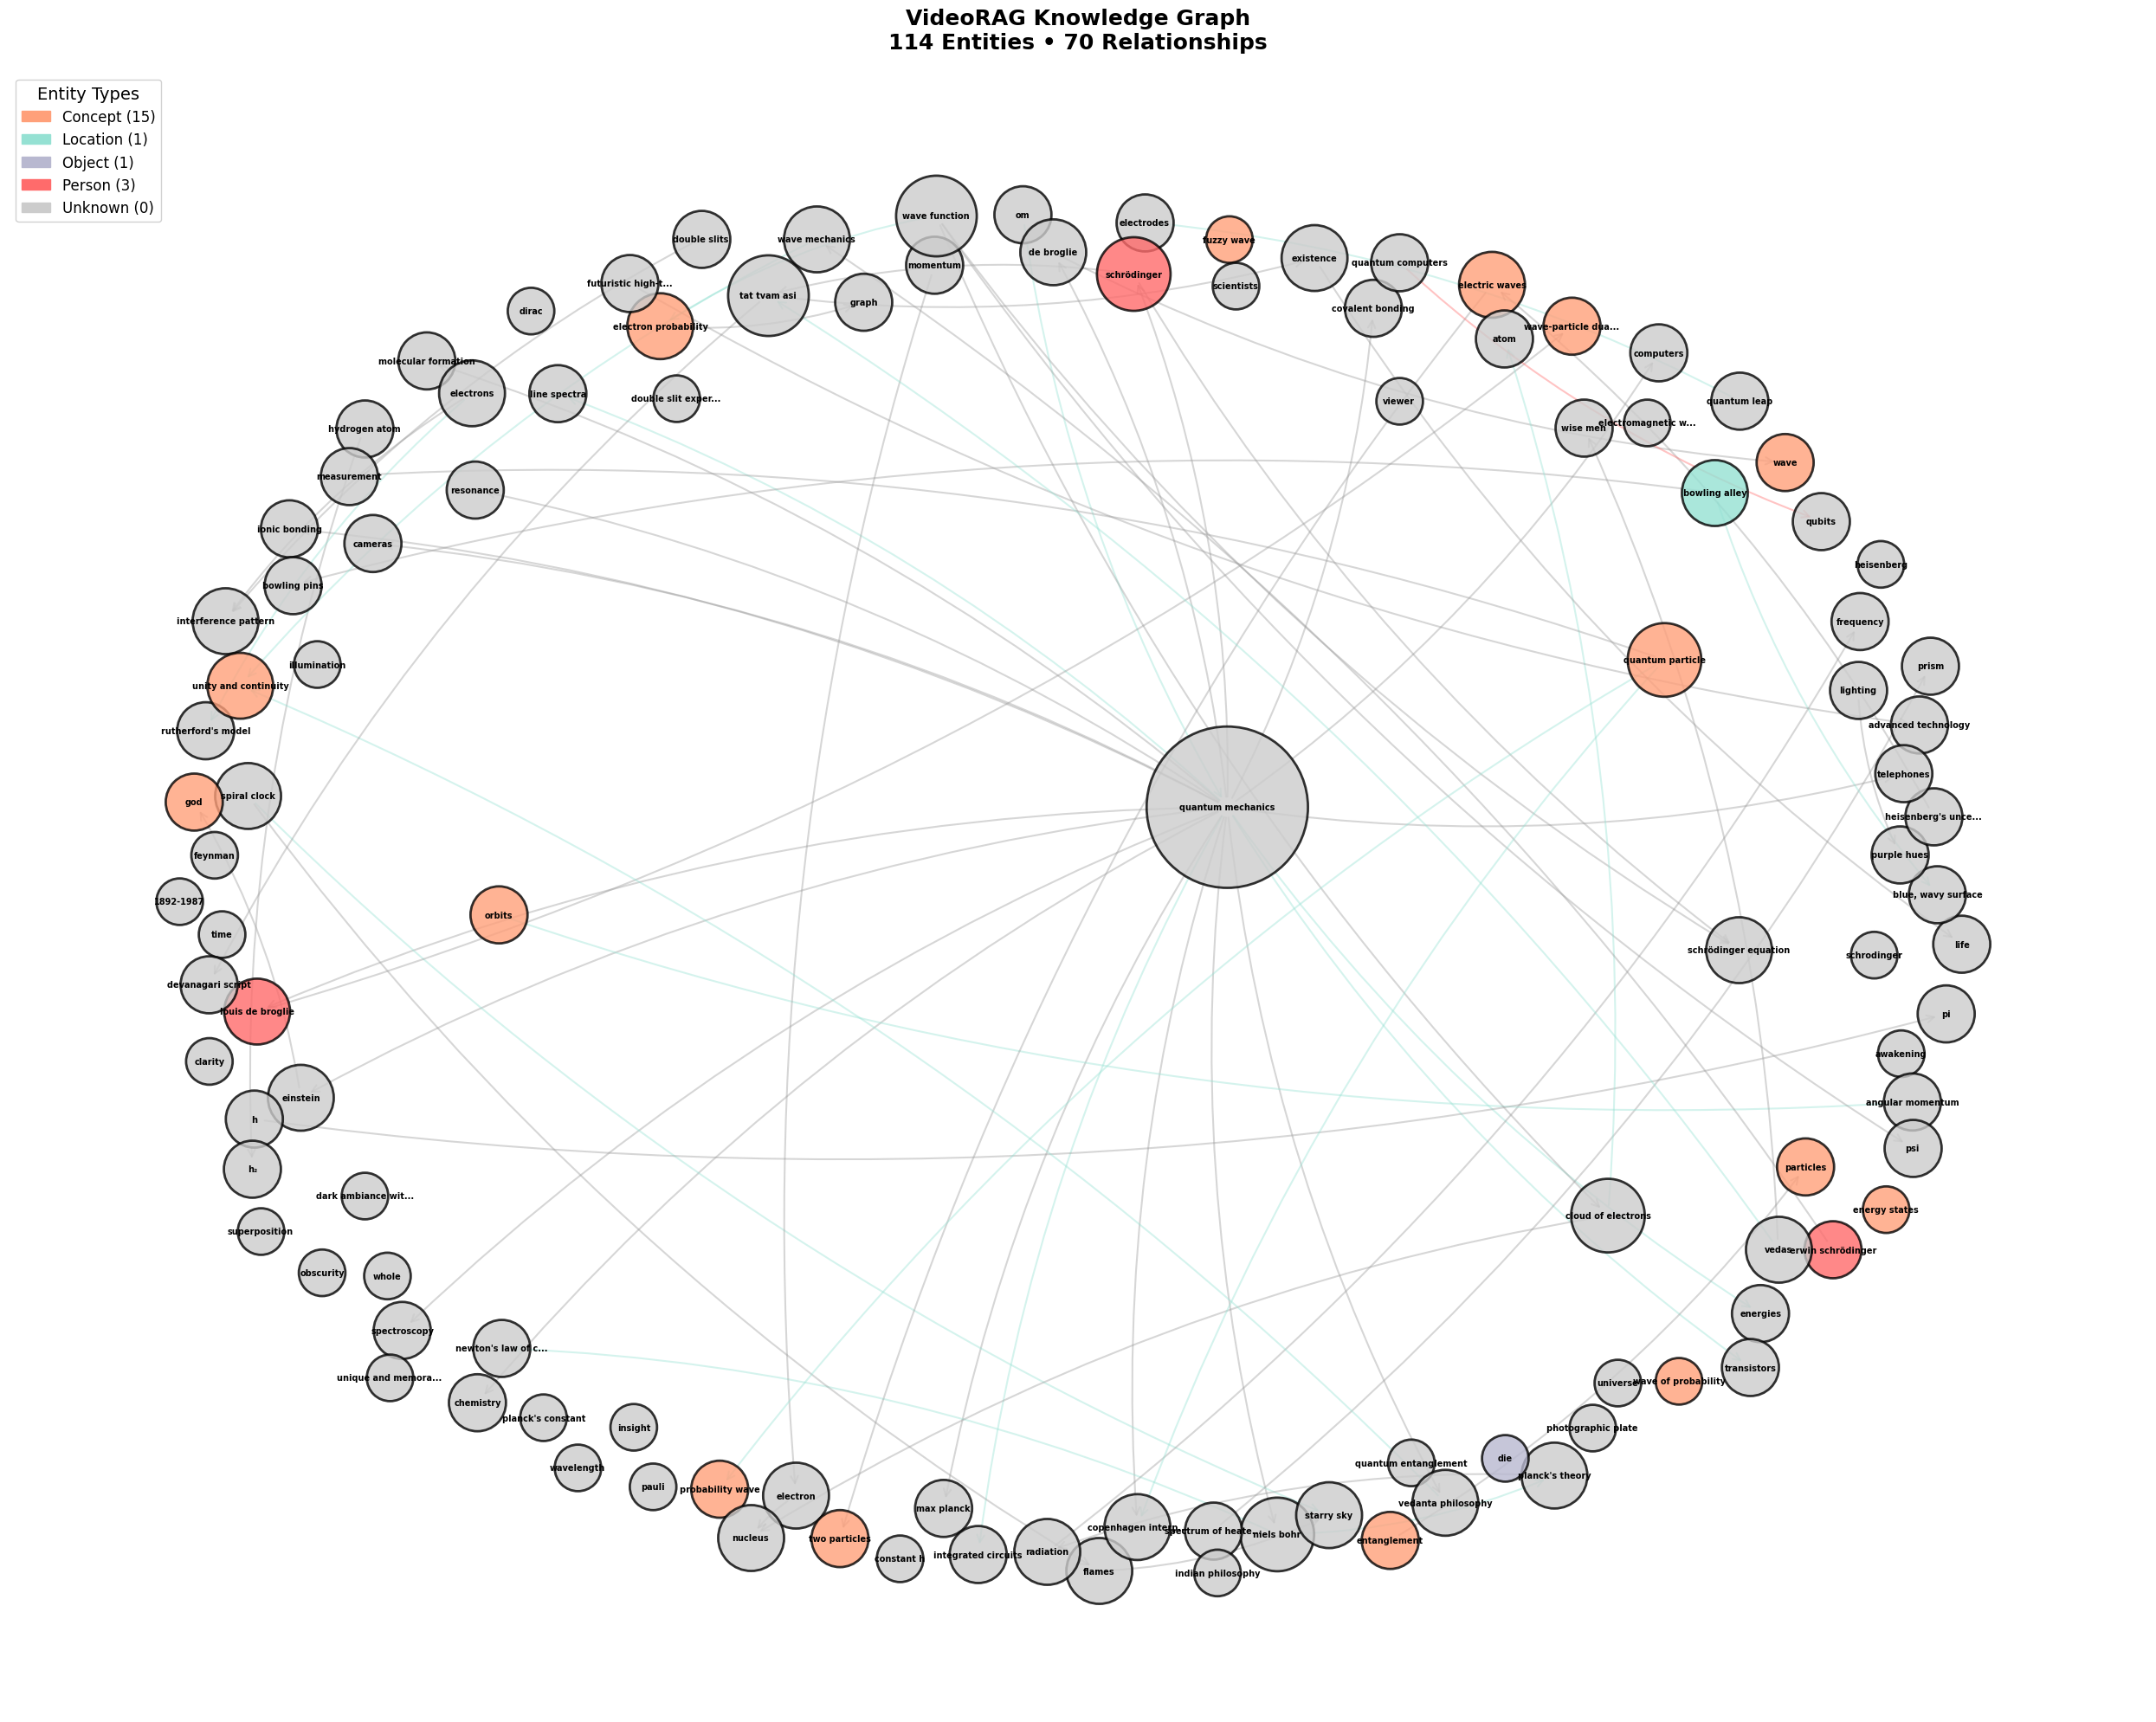


 VISUALIZATION COMPLETE

💡 VISUAL INSIGHTS:
   • Node size = Number of connections
   • Node color = Entity type
   • Edge arrows = Relationship direction
   • Edge color = Relationship type

🎯 TOP 3 CENTRAL ENTITIES (largest nodes):
   1. 'quantum mechanics' - Connected to 22 other entities
   2. 'wave function' - Connected to 4 other entities
   3. 'tat tvam asi' - Connected to 4 other entities



In [13]:
# ============================================================================
# CELL: Knowledge Graph VISUAL Visualization (Run AFTER statistics cell)
# ============================================================================

print("\n" + "="*70)
print(" VISUALIZING KNOWLEDGE GRAPH")
print("="*70 + "\n")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

if not graph_engine.G.number_of_nodes():
    print("❌ Knowledge graph is empty! Run video indexing first.\n")
else:
    # Determine figure size based on graph size
    num_nodes = graph_engine.G.number_of_nodes()
    
    if num_nodes < 20:
        figsize = (15, 12)
        node_size = 3000
        font_size = 10
    elif num_nodes < 50:
        figsize = (20, 16)
        node_size = 2000
        font_size = 8
    else:
        figsize = (25, 20)
        node_size = 1500
        font_size = 7
    
    print(f"📊 Generating visualization for {num_nodes} entities...\n")
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    
    # Use spring layout for better separation
    print("   🔧 Computing optimal layout...")
    pos = nx.spring_layout(graph_engine.G, k=2, iterations=50, seed=42)
    
    # ===== COLOR NODES BY TYPE =====
    node_types = {}
    for node, data in graph_engine.G.nodes(data=True):
        node_type = data.get('type', 'unknown')
        if node_type not in node_types:
            node_types[node_type] = []
        node_types[node_type].append(node)
    
    # Color palette for different entity types
    type_colors = {
        'person': '#FF6B6B',      # Red
        'organization': '#4ECDC4', # Teal
        'location': '#95E1D3',     # Light green
        'concept': '#FFA07A',      # Light salmon
        'event': '#DDA15E',        # Brown
        'object': '#B8B8D0',       # Light purple
        'time': '#F9C74F',         # Yellow
        'unknown': '#CCCCCC'       # Gray
    }
    
    # ===== DRAW EDGES (RELATIONSHIPS) =====
    print("   🔗 Drawing relationships...")
    
    # Group edges by relation type
    edge_colors = []
    edge_widths = []
    edge_styles = []
    
    for source, target, data in graph_engine.G.edges(data=True):
        relation = data.get('relation', 'related_to')
        
        # Different colors for different relation types
        if 'work' in relation.lower() or 'employ' in relation.lower():
            edge_colors.append('#FF6B6B')  # Red for work relationships
        elif 'located' in relation.lower() or 'in' in relation.lower():
            edge_colors.append('#95E1D3')  # Green for location
        elif 'created' in relation.lower() or 'made' in relation.lower():
            edge_colors.append('#4ECDC4')  # Teal for creation
        else:
            edge_colors.append('#999999')  # Gray for generic
        
        edge_widths.append(1.5)
        edge_styles.append('solid')
    
    nx.draw_networkx_edges(
        graph_engine.G, pos,
        edge_color=edge_colors,
        width=edge_widths,
        style=edge_styles,
        alpha=0.4,
        arrows=True,
        arrowsize=15,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.1',
        ax=ax
    )
    
    # ===== DRAW NODES (ENTITIES) =====
    print("   🎯 Drawing entities...")
    
    for node_type, nodes in node_types.items():
        color = type_colors.get(node_type, type_colors['unknown'])
        
        # Size nodes by number of connections
        node_sizes = [node_size * (1 + 0.5 * graph_engine.G.degree(node)) for node in nodes]
        
        nx.draw_networkx_nodes(
            graph_engine.G, pos,
            nodelist=nodes,
            node_color=color,
            node_size=node_sizes,
            alpha=0.8,
            edgecolors='black',
            linewidths=2,
            ax=ax
        )
    
    # ===== DRAW LABELS =====
    print("   🏷️  Adding labels...")
    
    # Create labels (truncate long names)
    labels = {}
    for node in graph_engine.G.nodes():
        if len(node) > 20:
            labels[node] = node[:17] + '...'
        else:
            labels[node] = node
    
    nx.draw_networkx_labels(
        graph_engine.G, pos,
        labels,
        font_size=font_size,
        font_weight='bold',
        font_color='black',
        ax=ax
    )
    
    # ===== ADD LEGEND =====
    legend_elements = []
    for node_type, color in sorted(type_colors.items()):
        if node_type in node_types or node_type == 'unknown':
            count = len(node_types.get(node_type, []))
            if count > 0 or node_type == 'unknown':
                legend_elements.append(
                    mpatches.Patch(color=color, label=f'{node_type.capitalize()} ({count})')
                )
    
    ax.legend(
        handles=legend_elements,
        loc='upper left',
        fontsize=12,
        framealpha=0.9,
        title='Entity Types',
        title_fontsize=14
    )
    
    # ===== TITLE AND FORMATTING =====
    plt.title(
        f'VideoRAG Knowledge Graph\n{num_nodes} Entities • {graph_engine.G.number_of_edges()} Relationships',
        fontsize=18,
        fontweight='bold',
        pad=20
    )
    
    ax.axis('off')
    plt.tight_layout()
    
    # ===== SAVE VISUALIZATION =====
    viz_path = os.path.join(Config.STORAGE_FOLDER, "knowledge_graph_visualization.png")
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n   ✅ Visualization saved to: {viz_path}")
    
    plt.show()
    
    print("\n" + "="*70)
    print(" VISUALIZATION COMPLETE")
    print("="*70 + "\n")
    
    # ===== INTERACTIVE GRAPH INSIGHTS =====
    print("💡 VISUAL INSIGHTS:")
    print(f"   • Node size = Number of connections")
    print(f"   • Node color = Entity type")
    print(f"   • Edge arrows = Relationship direction")
    print(f"   • Edge color = Relationship type")
    print()
    
    # Find central hubs
    degree_centrality = nx.degree_centrality(graph_engine.G)
    top_3_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print("🎯 TOP 3 CENTRAL ENTITIES (largest nodes):")
    for i, (entity, centrality) in enumerate(top_3_hubs, 1):
        print(f"   {i}. '{entity}' - Connected to {graph_engine.G.degree(entity)} other entities")
    print()

In [14]:
print("\n" + "="*70)
print(" STEP 2: QUERY YOUR VIDEO")
print("="*70 + "\n")

# Example queries
example_queries = [
    "What is the main topic discussed in this video?",
    "Summarize the key points mentioned",
    "What visual scenes are shown?",
    "Who are the people mentioned or shown?"
]

print("💡 Example queries:")
for i, q in enumerate(example_queries, 1):
    print(f"   {i}. {q}")
print()

# ⚠️ CHANGE THIS to your query
user_query = "What is the main topic discussed in this video?"

# Run query
result = query_videorag(user_query)

# Display results
print("\n" + "="*70)
print(" RESULTS")
print("="*70 + "\n")

display(Markdown(f"### Question\n{user_query}\n"))
display(Markdown(f"### Answer\n{result['answer']}\n"))

if result['sources']:
    display(Markdown("### Retrieved Sources"))
    for i, src in enumerate(result['sources'], 1):
        display(Markdown(f"**Source {i}** [{src['start']}-{src['end']}s]"))
        display(Markdown(f"```\n{src['text'][:200]}...\n```\n"))


 STEP 2: QUERY YOUR VIDEO

💡 Example queries:
   1. What is the main topic discussed in this video?
   2. Summarize the key points mentioned
   3. What visual scenes are shown?
   4. Who are the people mentioned or shown?


🔍 Processing Query: What is the main topic discussed in this video?



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📋 Query Plan:
   • Visual: What is the main topic discussed in this video?
   • Textual: main topic, discussed, video
   • Entities: []

🎨 Running visual retrieval...
   ✅ Found 3 visual matches

📝 Running textual retrieval...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   ✅ Found 3 textual matches

📚 Retrieved 6 unique chunks

🤖 Generating answer...



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



 RESULTS



### Question
What is the main topic discussed in this video?


### Answer
The main topic discussed in this video is an introduction to quantum mechanics, including its principles, historical context, and prominent scientists like Schrödinger, Einstein, and others. The video covers fundamental concepts such as the behavior of particles, wave functions, quantum entanglement, and their implications in modern technology [0s-30s][120s-150s][210s-240s].


### Retrieved Sources

**Source 1** [0-30s]

```
Time: 0-30s. Transcript: My greetings, I'm Om. Today I'm going to give a small introduction to quantum mechanics. Quantum mechanics have mathematically described most of chemistry, ionic and covalent ...
```


**Source 2** [30-60s]

```
Time: 30-60s. Transcript: Dirac, Heisenberg, Pauli, Schrodinger, Feynman, etc. The pioneering explanation given by quantum mechanics was for the line spectra of a hydrogen atom. When scientists observ...
```


**Source 3** [120-150s]

```
Time: 120-150s. Transcript: electron's position times the range of its momentum is more than equal to h by 4 pi. Schrodinger postulated that if electron is a wave, it can exist anywhere in the three-d...
```


**Source 4** [180-210s]

```
Time: 180-210s. Transcript: nature. Thus, all the particles are waves of probabilities until measured. This measurement collapses the probability wave of the particle such that it then becomes a disti...
```


**Source 5** [210-240s]

```
Time: 210-240s. Transcript: is still observed even if they are separated by a great distance. Their properties remain linked. Einstein termed this as spooky action at a distance. In fact, quantum mech...
```


**Source 6** [270-278.75s]

```
Time: 270-278.75s. Transcript: existence. Like quantum mechanics, the mystical formula of Vedas say the same. Tat Tvam Asi. I am everywhere. I am this entire world. Thank you.. Visual Scene: The image...
```


In [16]:
# ⚠️ CHANGE THIS to your query
user_query = "Who are the people mentioned or shown?"

# Run query
result = query_videorag(user_query)

# Display results
print("\n" + "="*70)
print(" RESULTS")
print("="*70 + "\n")

display(Markdown(f"### Question\n{user_query}\n"))
display(Markdown(f"### Answer\n{result['answer']}\n"))

if result['sources']:
    display(Markdown("### Retrieved Sources"))
    for i, src in enumerate(result['sources'], 1):
        display(Markdown(f"**Source {i}** [{src['start']}-{src['end']}s]"))
        display(Markdown(f"```\n{src['text'][:200]}...\n```\n"))


🔍 Processing Query: Who are the people mentioned or shown?



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📋 Query Plan:
   • Visual: Identify and list the individuals depicted or referred to in the content.
   • Textual: Identify people mentioned or shown
   • Entities: []

🎨 Running visual retrieval...
   ✅ Found 3 visual matches

📝 Running textual retrieval...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   ✅ Found 3 textual matches

📚 Retrieved 4 unique chunks

🤖 Generating answer...



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



 RESULTS



### Question
Who are the people mentioned or shown?


### Answer
The people mentioned or shown in the video are:

1. **Louis de Broglie** - He proposed that an electron is probably a wave and contributed to the concepts of quantum mechanics and wave-particle duality [90s-120s].
2. **Erwin Schrödinger** - He postulated that if an electron is a wave, it can exist anywhere in three-dimensional space and formulated the Schrödinger equation, which became fundamental in quantum mechanics [120s-150s].
3. **Schrödinger** is also quoted discussing the relationship between quantum mechanics and Vedanta philosophy, indicating a connection between these fields of thought [240s-270s].


### Retrieved Sources

**Source 1** [90-120s]

```
Time: 90-120s. Transcript: in Rutherford's model to explain that electrons exist in special orbits without radiating photons, and only those orbits where angular momentum of the electron is quantized....
```


**Source 2** [120-150s]

```
Time: 120-150s. Transcript: electron's position times the range of its momentum is more than equal to h by 4 pi. Schrodinger postulated that if electron is a wave, it can exist anywhere in the three-d...
```


**Source 3** [240-270s]

```
Time: 240-270s. Transcript: entanglement and superposition to create revolutionary new technologies like quantum computers. They work on qubits and are fastest ultimate computing machines. Is there a ...
```


**Source 4** [270-278.75s]

```
Time: 270-278.75s. Transcript: existence. Like quantum mechanics, the mystical formula of Vedas say the same. Tat Tvam Asi. I am everywhere. I am this entire world. Thank you.. Visual Scene: The image...
```


In [15]:
print("\n" + "="*70)
print(" INTERACTIVE MODE")
print("="*70 + "\n")

def interactive_query():
    """Run interactive query loop"""
    print("Type your questions (or 'quit' to exit):\n")
    
    while True:
        query = input("❓ Your question: ").strip()
        
        if query.lower() in ['quit', 'exit', 'q']:
            print("\n👋 Goodbye!")
            break
        
        if not query:
            continue
        
        try:
            result = query_videorag(query)
            print("\n" + "─"*70)
            print(f"💡 Answer:\n{result['answer']}")
            print("─"*70 + "\n")
        except Exception as e:
            print(f"❌ Error: {e}\n")

# Uncomment to run interactive mode
# interactive_query()

print("✅ VideoRAG notebook complete! Ready to use.")


 INTERACTIVE MODE

✅ VideoRAG notebook complete! Ready to use.
